# Modeling

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from great_tables import GT, style, from_column, loc

### Defined Function

In [ ]:
def runModel(data, verbose = False):
    """
    This function runs a logistic regression model to produce catch probabilities.
    Inputs: Dataframe of data used in model, string of the venue of interest, and 
            a boolean of whether to produce a ROC plot and print metrics to screen.
    Outputs: Returns dataframes containing a single run of the model containing 
             catch probability, feature coefficients, and evaluation metrics. When
             verbose = True, dataframes contain the average of evaluation metrics.                       
    """

    # Split into features and targets for all data.
    targets = data['catch'].astype(int)
    feats = data.drop(columns=['play_key', 'catch',])

    # Initialize accumulators.
    accs, precs, recs, f1s, aucs = [], [], [], [], []

    if verbose:

        # Initialize pipeline.
        log_model = make_pipeline(StandardScaler(), LogisticRegression())
        
        # Initialize k-folds.
        k_fold = StratifiedKFold(n_splits = 20, shuffle = True)

        # Set accumulator for true positive rates and line for random chance.
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)

        # For loop to perform cross-validation.
        for train_idx, test_idx in k_fold.split(feats, targets):
            
            # Fit the model.
            log_model.fit(feats.iloc[train_idx], targets.iloc[train_idx])
            
            # Get the probability, get boolean prediction, and convert to integer for metrics.
            target_probs = log_model.predict_proba(feats.iloc[test_idx])[:, 1]
            target_preds = (target_probs >= 0.5).astype(int)

            # Collect metrics and add to accumulators.
            fpr, tpr, _ = roc_curve(targets.iloc[test_idx], target_probs)
            aucs.append(auc(fpr, tpr))
            accs.append(accuracy_score(targets.iloc[test_idx], target_preds))
            precs.append(precision_score(targets.iloc[test_idx], target_preds))
            recs.append(recall_score(targets.iloc[test_idx], target_preds))
            f1s.append(f1_score(targets.iloc[test_idx], target_preds))

            # Interp metrics for clean mean line, and append to true positive rates.
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)
            
        # Plot the different ROCs.
        plt.figure(figsize=(10, 6))

        # For loop to plot each line.
        for i in range(len(tprs)):
            plt.plot(mean_fpr, tprs[i], alpha = 0.3)
    
        # Get the mean roc and auc score.
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        # plot the mean ROC.
        plt.plot(mean_fpr, mean_tpr, color = 'b', label = f'Mean ROC (AUC = {mean_auc:.3f})', linewidth = 1.5)
        
        # plot the random line.
        plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Chance')

        # Add labels.
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Across K-Folds')
        plt.legend()
        plt.show()

        # Report metrics to screen.
        weights = pd.Series(log_model.named_steps['logisticregression'].coef_[0], index = feats.columns).sort_values()
        print('\nFeature Weights:')
        print(weights)

        print("\nLogistic Regression Metrics Across Folds:")
        print(f"Accuracy : {np.mean(accs):.3f}")
        print(f"Precision: {np.mean(precs):.3f}")
        print(f"Recall   : {np.mean(recs):.3f}")
        print(f"F1 Score : {np.mean(f1s):.3f}")


        # Calculate standard errors across folds
        acc_se = round(np.std(accs, ddof = 1) / np.sqrt(len(accs)), 3)
        prec_se = round(np.std(precs, ddof = 1) / np.sqrt(len(precs)), 3)
        rec_se = round(np.std(recs, ddof = 1) / np.sqrt(len(recs)), 3)
        f1_se = round(np.std(f1s, ddof = 1) / np.sqrt(len(f1s)), 3)
        auc_se = round(np.std(aucs, ddof = 1) / np.sqrt(len(aucs)), 3)
        
        # Print standard errors
        print("\nStandard Errors Across Folds:")
        print(f"Accuracy SE : {acc_se:.3f}")
        print(f"Precision SE: {prec_se:.3f}")
        print(f"Recall SE   : {rec_se:.3f}")
        print(f"F1 Score SE : {f1_se:.3f}")
        print(f"AUC SE      : {auc_se:.3f}")
        
        
    # Initialize model for single run.
    log_model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 44))
    
    # Fit on venue specific data.
    log_model.fit(feats, targets)

    # Get the probability and total prediction for metrics.
    probs = log_model.predict_proba(feats)[:, 1]
    preds = (probs >= .5).astype(int)

    # Calculate metrics for single run and append to accumulators.
    if not verbose:
            accs.append(accuracy_score(targets, preds))
            precs.append(precision_score(targets, preds))
            recs.append(recall_score(targets, preds))
            f1s.append(f1_score(targets, preds))
            fpr, tpr, _ = roc_curve(targets, probs)
            aucs.append(auc(fpr, tpr))
                
    # Create Dataframes for results, coefficients, and metrics.
    results = pd.DataFrame({'play_key': data['play_key'],
                            'catch': data['catch'].astype(int),
                            'probability': probs})

    coeffs = pd.DataFrame({'feature': feats.columns,
                           'coeff': log_model.named_steps['logisticregression'].coef_[0]})

    coeffs['coeff'] = coeffs['coeff'].round(3)

    metrics = pd.DataFrame({'metric': ['accuracy', 'precision', 'recall', 'f1', 'auc'],
                            'value': np.round([np.mean(accs), 
                                               np.mean(precs), 
                                               np.mean(recs),
                                               np.mean(f1s), 
                                               np.mean(aucs)], 3),
                            'sde': [acc_se, prec_se, rec_se, f1_se, auc_se]})


    return results, coeffs, metrics

## Data

**play_key**: Unique identifier that is the combination of the `game_str` and `play_id`. Used to attribute catch probability back to the play.

**hangtime**: The amount of time from the hit to the result measured in seconds. Input feature.

**backwards**: Binary feature indicating if the batted ball result was toward the outfield wall from the player's starting position. Input feature.

**dist_to_result**: The Euclidean distance from the player's starting location to the location of the batted ball result. Input feature.

**catch**: Binary feature indicating whether the ball was caught or not. Target feature.

In [2]:
# Load in data
model_data = pd.read_csv('data/model_data.csv')

model_data

,play_key,hangtime,backwards,dist_to_result,catch
0,y1_d057_KJH_RZQ_287,2.50,0,50.662396,False
1,y1_d045_MHY_RZQ_8,5.95,0,7.853307,True
2,y1_d076_GAX_YJD_35,6.75,0,97.029806,True
3,y1_d092_DYE_RZQ_21,3.05,0,61.658996,False
4,y2_d093_QZE_RZQ_55,4.15,1,57.918066,True
...,...,...,...,...,...
4024,y1_d045_VHS_YJD_179,5.80,0,33.403678,True
4025,y1_d081_FBP_QEA_23,3.10,0,73.768696,False
4026,y1_d032_REC_QEA_114,2.74,0,44.539176,False
4027,y1_d094_WNA_RZQ_51,5.45,0,68.413032,True


## Preprocessing Considerations

Preprocessing and evaluation considerations for the model included stratified k-fold cross-validation and standard scaling of the input features. Due to the sample having more balls converted to outs than not, stratified k-folds were implemented to account for the oversaturation of positive results. The features were scaled due to hangtime having a range of 2 to 8 seconds and distance to result having a range of 0 to 135 feet. 

## Run Model

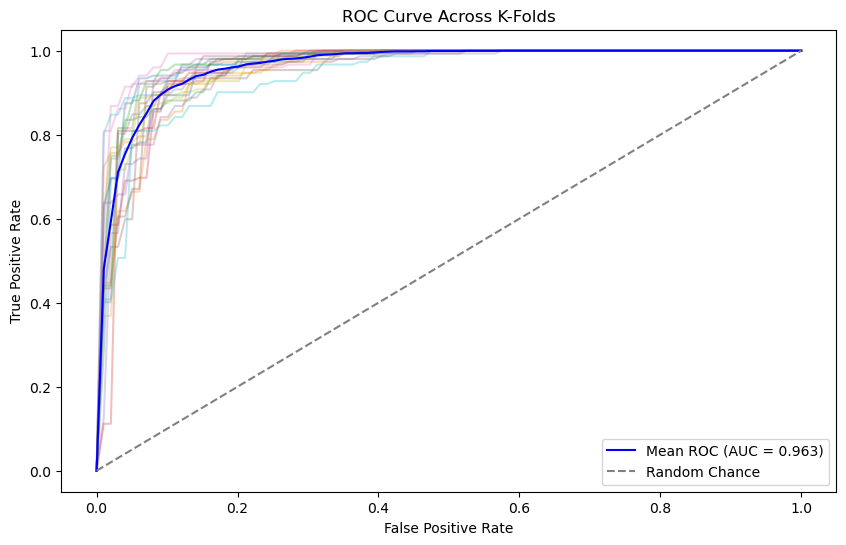


Feature Weights:
dist_to_result   -3.906509
backwards        -0.492120
hangtime          4.820164
dtype: float64

Logistic Regression Metrics Across Folds:
Accuracy : 0.927
Precision: 0.945
Recall   : 0.959
F1 Score : 0.952

Standard Errors Across Folds:
Accuracy SE : 0.004
Precision SE: 0.003
Recall SE   : 0.004
F1 Score SE : 0.003
AUC SE      : 0.002


In [4]:
results, coeffs, metrics = runModel(model_data, verbose = True)

In [5]:
for feat in model_data.columns[1:4]:
    if feat != 'backwards':
        print(f'Descriptive Statistics for {feat}:')
        print(f'Mean: {model_data[feat].mean():.3f}')
        print(f'Standard Deviation: {model_data[feat].std():.3f}')
        print(f'For every {model_data[feat].std():.3f} change in {feat}, the probability of catching the ball changes by {coeffs.loc[coeffs["feature"] == feat, "coeff"].values[0]:.3f}\n')
    else:
        print(f'When the fielder has to move backwards, the probability of catching the ball changes by {coeffs.loc[coeffs["feature"] == feat, "coeff"].values[0]:.3f}\n')

Descriptive Statistics for hangtime:
Mean: 4.413
Standard Deviation: 1.192
For every 1.192 change in hangtime, the probability of catching the ball changes by 4.762

When the fielder has to move backwards, the probability of catching the ball changes by -0.474

Descriptive Statistics for dist_to_result:
Mean: 55.585
Standard Deviation: 23.777
For every 23.777 change in dist_to_result, the probability of catching the ball changes by -3.833



In [6]:
# Rename for better image.
coeffs['feature'] = ['Hangtime', 'Backwards', 'Distance to Result']

# Create Great Table.
(GT(coeffs)
  # Title
 .tab_header('Feature Weights')
  # Rename columns.
 .cols_label(feature = 'Features',
             coeff = 'Weight')
  # Polish and save.
 .cols_align('center')
 .save('data/images/figures/model_weights.png',
       scale = 2.0)
 .show())

Feature Weights 
 
 
 Features 
 Weight 
 
 
 
 
 Hangtime 
 4.762 
 
 
 Backwards 
 -0.474 
 
 
 Distance to Result 
 -3.833

In [7]:
# This cell will overwrite the files used for the project's analysis. If needed to run model again and store results, feel free to uncomment.
# Save results to csvs for submission and analysis.
#results.to_csv('data/catch_probabilities.csv', index = False)
#metrics.to_csv('data/metrics.csv', index = False)
#coeffs.to_csv('data/coeffs.csv', index = False)